# Workshop 10: Multi-armed bandits
***
In this worksheet we cover:
* [multi-armed bandits](#Multi-armed-bandits)
* [the epsilon-greedy strategy](#Epsilon-greedy-strategy)
* [the upper confidence bound](#Upper-Confidence-Bound)
* [offline evaluation of multi-armed bandits](#Offline-evaluation)

Below we import the packages required for this worksheet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

***

## Media recommendation
In this workshop, we consider the problem of choosing articles to recommend to users on a news website. The articles correspond to actions and clicks correspond to rewards (assumed to be {0, 1}-valued). The per round cumulative reward corresponds to the click-through-rate (CTR), which is exactly what news services want to maximise to drive user engagement and advertising revenue.

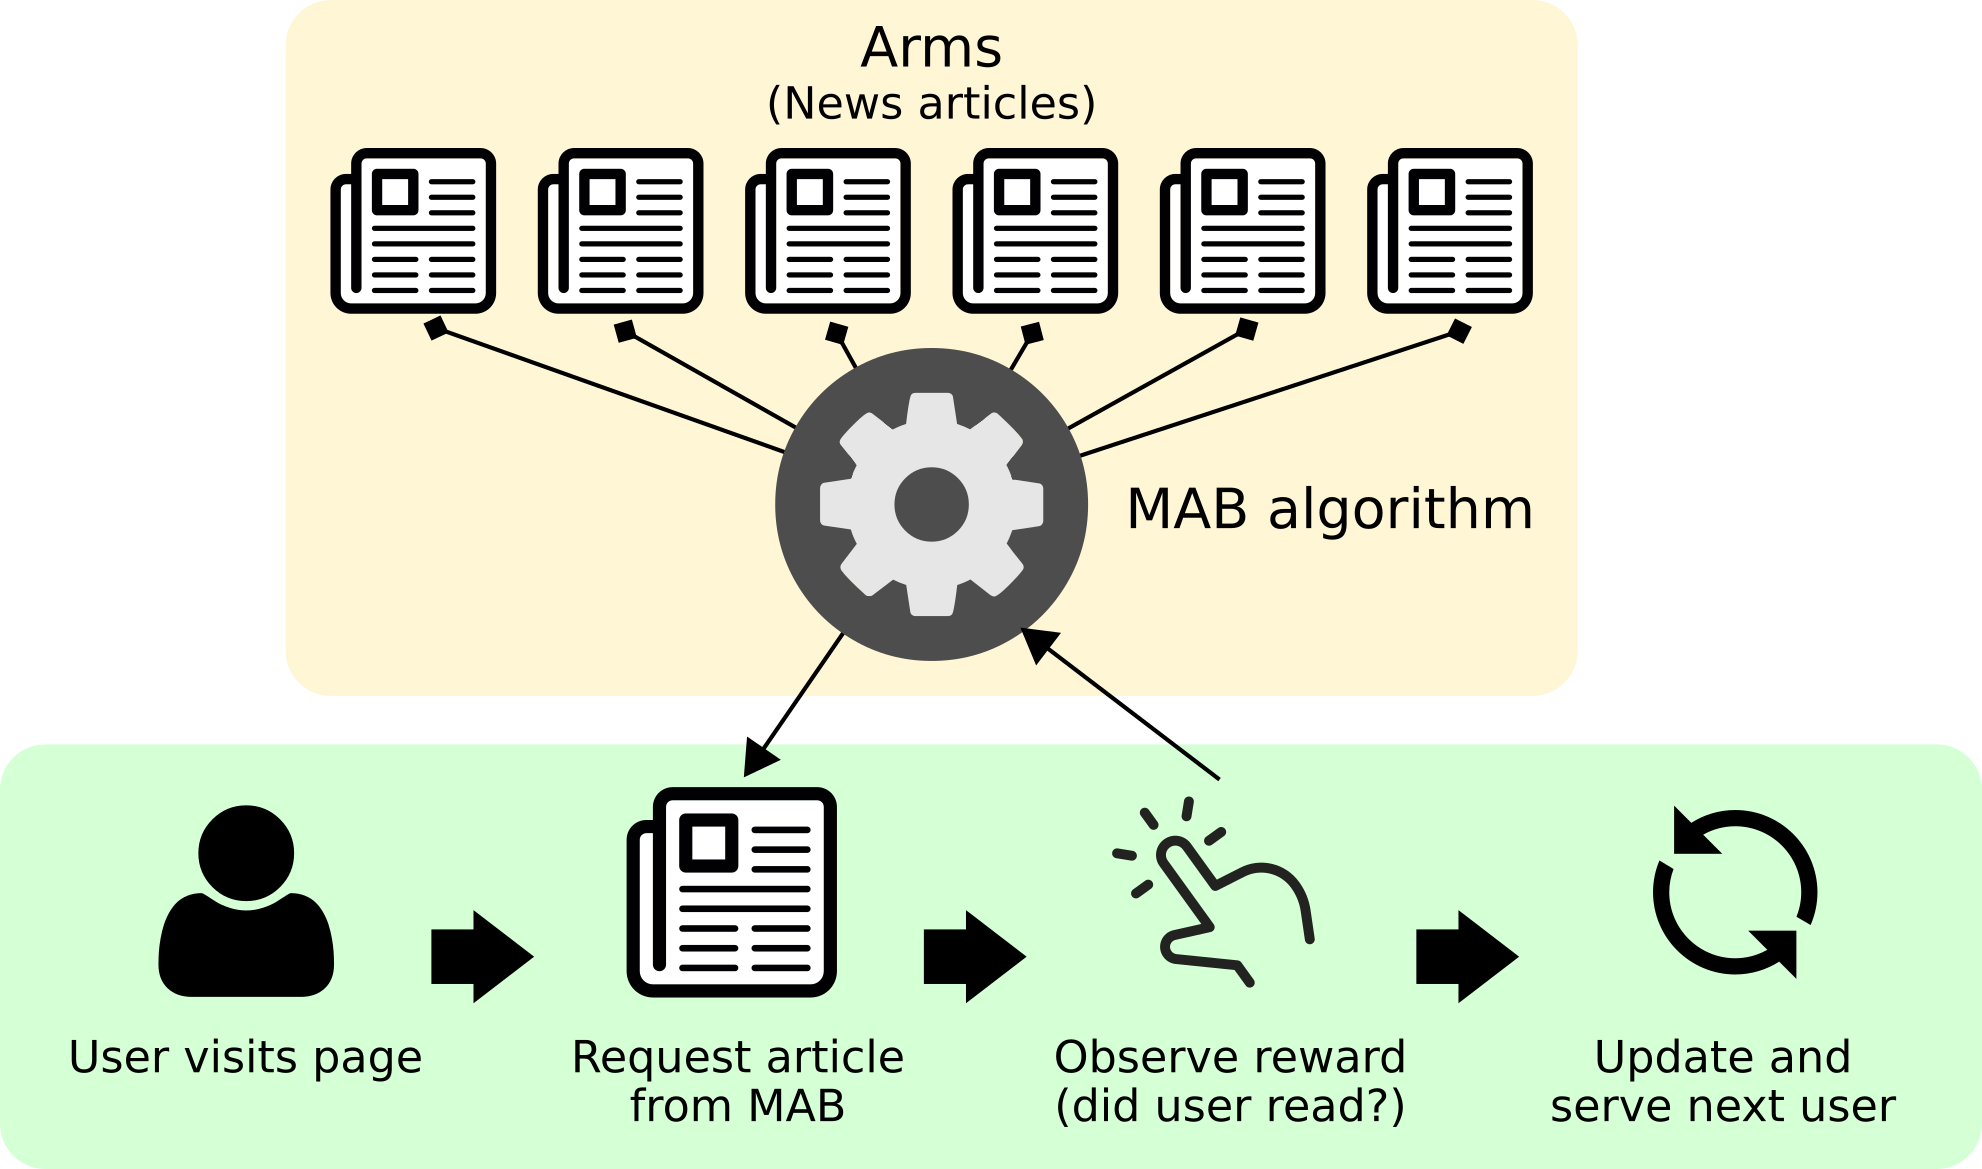

In this worksheet, we'll assume information about the articles and users ("context") is not available, which corresponds to the simplest MAB setting. However if such information were available, we could apply contextual bandits (covered briefly in lectures).

## Multi-armed bandits
### Technical definition
The multi-armed bandit (MAB) models an agent that must take actions ("pull arms") so as to maximize the cumulative reward received over a finite number of rounds $T$.
In this worksheet, we index the $K$ arms by $k \in \{0, \ldots, K-1\}$ (starting at zero to match Python indexing).
The reward received from pulling arm $k$ is assumed to follow some distribution $\mathcal{D}_k$ with mean $\mu_k$, however this information is unknown to the agent.

The goal is to minimize the expected regret

$$
R = \underbrace{T \mu^\star}_{\text{optimal strategy}} - \underbrace{\sum_{t = 1}^{T} r_t}_{\text{executed strategy}}
$$

where $T$ is the number of rounds, $r_t$ is the reward received at round $t$ and $\mu^\star = \arg \max_k \mu_k$ is the maximum mean reward.

Other notation:
* $a_t$: index of the arm played at round $t$
* $N_{t,k} = \sum_{\tau = 1}^{t} \mathbb{I}[a_\tau = k]$: number of plays for arm $k$ at the end of round $t$



### Implementation details
We'll be implementing epsilon-greedy MAB. It will be implemented as classes which derive from a common base class `BaseMAB` defined in the code block below.

There are only two public methods:
* `play`: use this to pull an arm
* `update`: use this to update the internal state of the MAB based on the reward received

Only a small amount of logic is implemented in `BaseMAB`. 
It sets the number of arms; initialises an array for recording the number of pulls of each arm; and does some basic input checking.

In [2]:
class BaseMAB(ABC):
    """
    Base class for a multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms
    
    Attributes
    ----------
    n_pulls : numpy.ndarray, shape=(n_arms,)
        Number of pulls for each arm
    """
    def __init__(self, n_arms):
        if not isinstance(n_arms, (int, np.integer)):
            raise TypeError("`n_arms` must be an int")
        if n_arms <= 0:
            raise ValueError("`n_arms` must be positive")
        self.n_arms = n_arms
        self.n_pulls = np.zeros(n_arms, dtype=int)
        
    @abstractmethod
    def play(self):
        """
        Play a round
        
        Returns
        -------
        arm : int
            A positive integer arm id in {0, ..., n_arms - 1}
        """
        pass
    
    @abstractmethod
    def update(self, arm, reward):
        """
        Updates the internal state of the MAB after playing a round
        
        Parameters
        ----------
        arm : int
            A positive integer arm id in {0, ..., n_arms - 1}
        
        reward : float
            Reward received from arm
        """
        if not isinstance(arm, (int, np.integer)):
            raise TypeError("`arm` must be an int")
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range [0, {}]".format(self.n_arms - 1))
        if not isinstance(reward, (int, np.integer, float, np.float64)):
            raise TypeError("`reward` must be a numeric scalar")

***
## Epsilon-greedy strategy
The epsilon-greedy strategy is arguably one of the simplest. 
When playing an arm, the current "best" arm is selected with probability $1-\epsilon$. 
Otherwise, an arm is selected uniformly at random (with probability $\epsilon$).
The current "best" arm is the one with the highest _estimated mean reward based_ on the rewards seen so far (with ties broken randomly).
We estimate the mean reward of arm $k$ at round $T$ as follows:

$$
Q_{t-1,k} = \begin{cases}
    \hat{\mu}_{t-1,k}, & N_{t-1,k} > 0 \\
    Q_0, & \text{otherwise}.
\end{cases}
$$

where $N_{t-1,k} = \sum_{\tau=1}^{t-1} \mathbb{I}[a_\tau = k]$ is the number of rewards observed for arm $k$ at round $t$ and $\hat{\mu}_{t-1,k} = \frac{1}{N_{t-1,k}} \sum_{\tau=1}^{t-1} r_{\tau} \mathbb{I}[a_\tau = k]$ is the sample mean.
Note the special case: if no rewards have been observed for an arm we use $Q_0$ (initial value) for the mean reward.

Thus the hyperparameters for the epsilon-greedy strategy are:
* $\epsilon$: the explore probability
* $Q_0$: the initial value for the estimated mean

Let's now implement the epsilon-greedy strategy.

**Exercise:** When implementing the logic to select the "best" arm, it will be useful to have a function that computes the argmax with random tie-breaking.
In the code block below, write a function `argmax_rand` that takes a vector of values for each arm, e.g.

$$
\mathbf{x} = \begin{pmatrix}
    Q_{t-1,0} & Q_{t-1,1} & \cdots & Q_{t-1,K-1}
\end{pmatrix}
$$

and returns the index $k^\star$ of the largest value

$$
k^\star \in \arg \max_{k \in \{0,\ldots,K-1\}} Q_{t-1,k}
$$

(if there's more than one $k^\star$ in this set, choose one uniformly at random).

In [3]:
def argmax_rand(x):
    """
    Argmax with ties broken uniformly at random
    
    Parameters
    ----------
    x : 1d numpy.ndarray
        Input array
    
    Returns
    -------
    argmax : int
        Integer index of the max value in x
    """
    max_value = np.max(x)
    max_indices = np.where(x == max_value)[0]
    
    if len(max_indices) == 0:
        # If there are no arms with max UCB values, choose uniformly at random
        return np.random.choice(len(x))
    else:
        # Randomly choose one of the indices if there are ties
        return np.random.choice(max_indices)


In the code block below, we provide a skeleton class for the epsilon-greedy strategy.

**Exercise:** Complete the implementation by writing the `play` and `update` methods.
The `argmax_rand` function defined above will come in handy when implementing the `play` method.

In [4]:
import numpy as np

class EpsGreedy(BaseMAB):
    """
    Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability in interval [0, 1]

    Q0 : float, optional
        Initial value for the arms
    
    Attributes
    ----------
    n_pulls : numpy.ndarray, shape=(n_arms,)
        Number of pulls for each arm
    
    mean_rewards : numpy.ndarray, shape=(n_arms,)
        Mean reward per arm
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.epsilon = float(epsilon)
        self.Q0 = float(Q0)
        if self.epsilon < 0 or self.epsilon > 1:
            raise ValueError("`epsilon` must be in the interval [0, 1]")
        self.mean_rewards = np.full(n_arms, self.Q0)
        
    def play(self):
        super().play()
        if np.random.rand() < self.epsilon:
            # Exploration: Randomly select an arm
            return np.random.choice(self.n_arms)
        else:
            # Exploitation: Select the arm with the highest estimated mean reward
            return np.argmax(self.mean_rewards)
    
    def update(self, arm, reward):
        super().update(arm, reward)
        # Update the mean reward estimate for the chosen arm
        self.n_pulls[arm] += 1
        self.mean_rewards[arm] = (self.mean_rewards[arm] * (self.n_pulls[arm] - 1) + reward) / self.n_pulls[arm]


***
## Upper Confidence Bound
The UCB strategy balances exploration and exploitation by choosing arms with not only high estimated mean reward but also high uncertainty. Specifically, it selects the arm with the highest upper confidence bound at each round, where the upper confidence bound of arm $k$ is defined as
$$
Q_{t-1,k} = \begin{cases}
    \hat{\mu}_{t-1,k} + c \sqrt{\frac{\log t}{N_{t-1,k}}}, & N_{t-1,k} > 0 \\
    Q_0, & \text{otherwise}.
\end{cases}
$$
where $N_{t-1,k}$ is the number of rewards observed for arm $k$ at round $t$, $\hat{\mu}_{t-1,k}$ is the sample mean, $t$ is the current round, and $c$ is a hyperparameter that controls the degree of exploration. The term $c \sqrt{\frac{\log t}{N_{t-1,k}}}$ is the exploration term, which is larger for arms that have been played fewer times or have higher variance.

The key hyperparameters for the UCB strategy is:

* $c$: the exploration parameter

**Exercise:** Implement update function for UCB

In [5]:
class UCB(BaseMAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    c : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, c, Q0=np.inf):
        super().__init__(n_arms)
        if not np.issubdtype(type(c), np.floating):
            raise TypeError("`c` must be a float")
        if c <= 0:
            raise ValueError("`c` must be positive")
        if not np.issubdtype(type(Q0), np.floating):
            raise ValueError("`Q0` must be a float")
        
        self.c = c
        self.Q0 = Q0
        self.n_pulls = np.zeros(n_arms)
        self.mean_rewards = np.full(n_arms, self.Q0)
        self.Q_values = np.copy(self.mean_rewards)
        self.n_rounds = 0
    
    def play(self):
        super().play()
        return argmax_rand(self.Q_values)
        
    def update(self, arm, reward):
        super().update(arm, reward)
        
        # Update the number of pulls for the chosen arm
        self.n_pulls[arm] += 1
        
        # Update the mean reward estimate for the chosen arm
        # Calculate the new mean based on the reward received and the previous mean
        self.mean_rewards[arm] = (self.mean_rewards[arm] * (self.n_pulls[arm] - 1) + reward) / self.n_pulls[arm]
        
        # Update the number of rounds
        self.n_rounds += 1
        
        # Update the UCB values for all arms
        for k in range(self.n_arms):
            if self.n_pulls[k] > 0:
                exploration_term = self.c * np.sqrt(np.log(self.n_rounds) / self.n_pulls[k])
                self.Q_values[k] = self.mean_rewards[k] + exploration_term

        # The bandit is now updated


We'll try out this implementation shortly, but first we need to understand how to evaluate a multi-armed bandit.

***
## Offline evaluation
Since MABs are inherently online algorithms, it would be natural to also conduct evaluation online. 
This might involve deploying a MAB algorithm in parallel with a competing algorithm and seeing which achieves the higher per round cumulative reward. 
However, in practice this can be costly as a MAB algorithm begins with little knowledge about the reward structure and must inevitably yield poor rewards in earlier rounds.
In our news website example, users would be exposed to uninteresting articles merely for the sake of evaluation.

Fortunately, there's an alternative option called _offline_ or _off-policy_ evaluation. This involves collecting a sequence of uniformly-random arm pulls and their corresponding rewards. Then any MAB of interest can be evaluated on this one historical data set---there's no need to run the MAB online to evaluate!

We've provided a function `offlineEvaluate` below which conducts offline evaluation using a given historical data set. If you're interested in learning more about offline evaluation, check out the reference below (not examinable):

> Lihong Li, Wei Chu, John Langford, Robert E. Schapire, ‘A Contextual-Bandit Approach to Personalized News Article Recommendation’, in Proceedings of the Nineteenth International Conference on World Wide Web (WWW 2010), Raleigh, NC, USA, 2010. https://arxiv.org/pdf/1003.0146.pdf

In [6]:
def offlineEvaluate(mab, arms, rewards, n_rounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        Multi-armed bandit strategy to evaluate
    
    arms : int numpy.ndarray, shape (n_events,) 
        Sequence of randomly selected arm ids (events)
    
    rewards : float numpy.ndarray, shape (n_events,)
        Sequence of rewards received for each event
        
    n_rounds : int, optional
        Number of matching events to evaluate `mab` on.
    
    Returns
    -------
    out : 1D float array
        Rewards for the matching events.
    """
    if not isinstance(mab, BaseMAB):
        raise TypeError("`mab` must be an instance of BaseMAB")
    
    if not isinstance(arms, np.ndarray):
        raise TypeError("`arms` must be a numpy.ndarray")
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1d array")
    arms = arms.astype(int)
    if np.setdiff1d(np.unique(arms), np.arange(mab.n_arms)).size != 0:
        raise ValueError("`arms` contains values not in [0,...,n_arms-1]")
    
    if not isinstance(rewards, np.ndarray):
        raise TypeError("`rewards` must be a numpy.ndarray")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1d array")
    if arms.shape != rewards.shape:
        raise ValueError("`arms` and `rewards` must have the same shape")
    rewards = rewards.astype(float)
#     rewards = np.float64(rewards)

    if n_rounds is not None:
        n_rounds = int(n_rounds)
        if n_rounds < 0:
            raise ValueError("`n_rounds` must be non-negative")    
    
    matched_ctr = 0
    matched_rewards = list()
    for i in range(arms.size):
        if n_rounds is not None and matched_ctr >= n_rounds:
            break
        arm = mab.play()
        if arm == arms[i]:
            mab.update(arm, rewards[i])
            matched_ctr += 1
            matched_rewards.append(rewards[i])
    return np.array(matched_rewards)

Let's now load a historical data set. 
It corresponds to a bandit problem with $K = 10$ arms (news articles).
There are 10,000 uniformly-random arm pulls along with the observed rewards.
There also happens to be a 10-dimensional context vector for each arm (modelling article/user features), however we discard this as we are not doing contextual bandits.

In [7]:
# Load event log from a bandit run
dataset = np.genfromtxt('dataset.txt.gz', dtype=np.int64)
arms = dataset[:,0] - 1
rewards = dataset[:,1].astype(float)
# contexts = dataset[:,2::].astype(float).reshape(-1,10,10) (don't need contexts)

Now we can evaluate our epsilon-greedy strategy and UCB strategy on this data set. We set $\epsilon = 0.01$ for epsilon-greedy and $c=1.0$ for UCB

In [8]:
epsgreedy_mab = EpsGreedy(10, epsilon=0.01,Q0=10)
results_EpsGreedy = offlineEvaluate(epsgreedy_mab, arms, rewards, n_rounds=800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.01625


In [9]:
ucb_mab = UCB(10, c=1.0)
results_UCB = offlineEvaluate(ucb_mab, arms, rewards, n_rounds=800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.10125


/var/folders/7q/7h5d5cp54fs6_718f38b_hd00000gn/T/ipykernel_26403/1835402886.py:43: RuntimeWarning: invalid value encountered in scalar multiply
  self.mean_rewards[arm] = (self.mean_rewards[arm] * (self.n_pulls[arm] - 1) + reward) / self.n_pulls[arm]


Let's plot the running average cumulative reward v.s. round

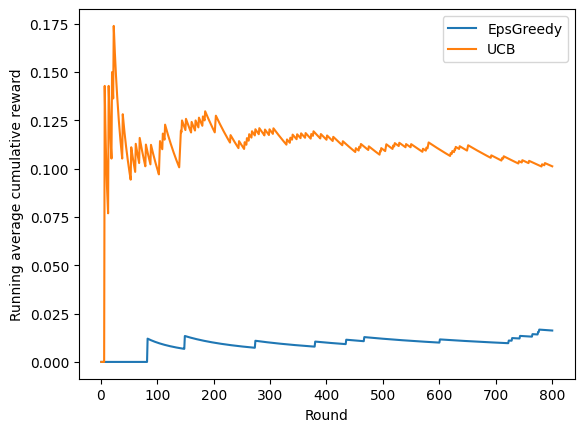

In [10]:
for mab in ['EpsGreedy', 'UCB']:
    results = eval('results_' + mab)
    t_round = np.arange(1, results.size + 1)
    cumsum = np.cumsum(results) / t_round
    plt.plot(t_round, cumsum, label=mab)
plt.legend()
plt.xlabel('Round')
plt.ylabel('Running average cumulative reward')
plt.show()